# Symplectic Euler Shadow Integration of mathematical pendulum

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ShadowIntegrators import *
from CreateTrainingData import *

## data creation for training

In [2]:
# setup problem for creation of training data
f = lambda x: -np.sin(x)
H = lambda x: 1/2*x[1]**2+(1-np.cos(x[0]))
h = 0.3
spacedim=[(-2*np.pi, 2*np.pi), (-1.2, 1.2)]
n_train = 160

In [3]:
# create traing data
start,final = CreateTrainingData(spacedim,f,n_train,h)

## initialisation and training

In [4]:
# initialise shadow integrator
SI = ShadowSEuler()

In [5]:
# train integrator
SI.train(start,final,h)          # output: residum of least square problem, rank of linear system

Start training with for 160 data points
Start computation of covariance matrix.
Covariance matrix of shape (160, 160)computed.
Start Cholesky decomposition of (160, 160) Matrix
Cholesky decomposition completed.
Create LHS of linear system for H at test points.
Creation of linear system completed.
Solve least square problem of dimension (321, 160)


(array([1.39997976e-07]), 160)

## prediction of motion and conservation of exact energy H

In [6]:
## predict a motion starting from z0
N = 4000
z0 = np.array([0.4,0.])

In [7]:
# use symplectic shadow integration
trj = SI.predictMotion(z0,N)

In [8]:
# integrate exact vector field for comparision
trjSE = SI.classicTrajectory(z0,lambda z: z[1],lambda z: f(z[0]),h,N)

In [9]:
# as a reference solution, compute exact vector field with tiny h
trj_ref = SI.classicTrajectory(z0,lambda z: z[1],lambda z: f(z[0]),h/800,N)

Text(0, 0.5, '$p$')

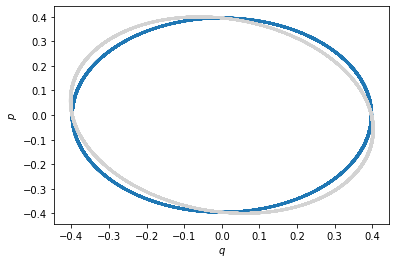

In [10]:
# compare
plt.plot(trj_ref[0],trj_ref[1],'k')
plt.plot(trj[0],trj[1])
plt.plot(trjSE[0],trjSE[1],color='lightgray')
plt.xlabel('$q$')
plt.ylabel('$p$')

Text(0, 0.5, '$H$')

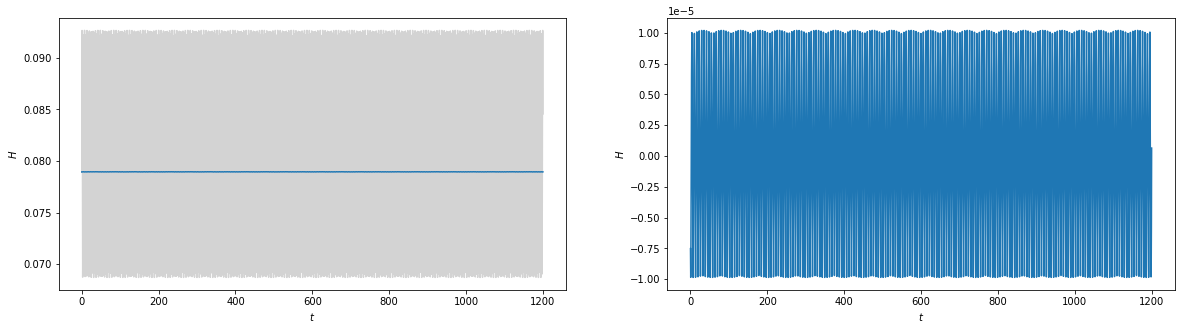

In [11]:
# plot energy conservation
Htrj = H(trj)

fig,ax = plt.subplots(1, 2,figsize=(20,5))
ax[0].plot(h*np.arange(0,len(trj[0,:])),H(trjSE),color='lightgray')
ax[0].plot(h*np.arange(0,len(trj[0,:])),Htrj)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$H$')
ax[1].plot(h*np.arange(0,len(trj[0,:])),Htrj-np.mean(Htrj))
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$H$')

## system identification

### phase plot

In [12]:
# creation of grid on phase space
n0 = 120
n1 = 120

yy0,yy1 = np.meshgrid(np.linspace(spacedim[0][0],spacedim[0][1],n0),np.linspace(spacedim[1][0],spacedim[1][1],n1))
Y = [ np.array([yy0[i,j],yy1[i,j]]) for i in range(0,n1) for j in range(0,n0) ]
Y = np.array(Y)

In [13]:
# compute recovered H over grid
HmodY = np.array([SI.HRecover(x) for x in Y])

In [14]:
# compute reference
n0 = 400
n1 = 400
yy0High,yy1High = np.meshgrid(np.linspace(spacedim[0][0],spacedim[0][1],n0),np.linspace(spacedim[1][0],spacedim[1][1],n1))
H_ref=H([yy0High,yy1High])


Text(0, 0.5, '$p$')

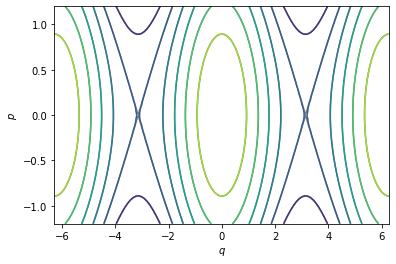

In [15]:
# compare recovered H with reference
plt.contour(yy0High,yy1High,H([yy0High,yy1High]),colors=['grey'])
plt.contour(yy0,yy1,np.reshape(HmodY[:,2],yy0.shape))
plt.xlabel('$q$')
plt.ylabel('$p$')

### conservation properties of recovered H along trajectory

In [16]:
# compute recovered H along trajectory
rYt=np.array([SI.HRecover(x) for x in trj.transpose()])

Text(0.5, 0, '$t$')

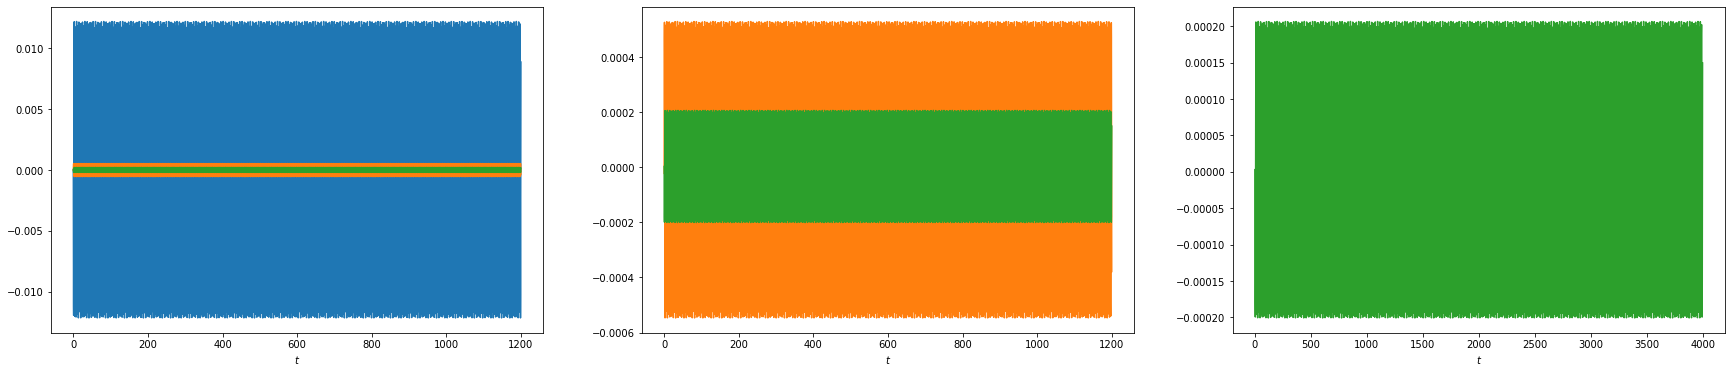

In [17]:
t=h*np.arange(0,len(rYt))
rYtm=np.mean(rYt,0)

fig, axs = plt.subplots(1, 3,figsize=(30,6))
axs[0].plot(t,rYt[:,0]-rYtm[0],t,rYt[:,1]-rYtm[1],t,rYt[:,2]-rYtm[2])
axs[1].plot(t,rYt[:,1]-rYtm[1],'C1',t,rYt[:,2]-rYtm[2],'C2')
axs[2].plot(rYt[:,2]-rYtm[2],'C2')

axs[0].set_xlabel('$t$')
axs[1].set_xlabel('$t$')
axs[2].set_xlabel('$t$')

## Comparison with SciKit GaussianProcessRegressor

In [18]:
# import libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Fit GP to data with scaled RBF kernel, using ML estimation of the parameters
kernel = C(6.62, (6.5,7)) * RBF(3.02, (2.5, 3.5)) # scaled RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1,random_state=0)
gp.fit(start.T,final.T) # Fit to data using ML Estimation of the parameters

GaussianProcessRegressor(kernel=2.57**2 * RBF(length_scale=3.02),
                         n_restarts_optimizer=1, random_state=0)

In [19]:
# predict trajectory using the learned flow map
trjSci = np.zeros((trj.shape[0],40001))
trjSci[:,0] = trj[:,0]

for j in range(0,trjSci.shape[1]-1):
    trjSci[:,j+1] = gp.predict(trjSci[:,j].reshape(1,-1))[0]

Text(0, 0.5, '$p$')

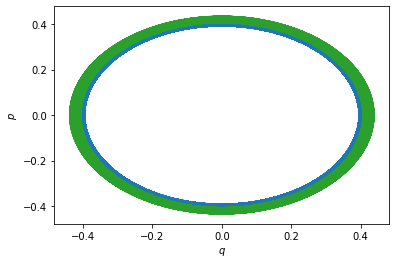

In [20]:
# phase plots
plt.plot(trjSci[0],trjSci[1],'C2')
plt.plot(trj_ref[0],trj_ref[1],'k')
plt.plot(trj[0],trj[1],'C0')
#plt.plot(trjSE[0],trjSE[1],'gray')
plt.xlabel('$q$')
plt.ylabel('$p$')

Text(0, 0.5, '$H$')

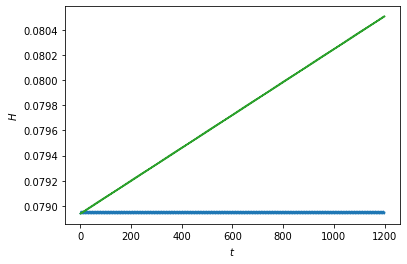

In [21]:
# compare energy plot
mm1 = len(trj[0])
mm = len(trj[0])

#plt.plot(    h*np.arange(0,mm),    H(trjSE[:,:mm]),'C1')
plt.plot(    h*np.arange(0,mm),    H(trj[:,:mm]), 'C0')
plt.plot(    h*np.arange(0,mm1),    H(trjSci[:,:mm1]),'C2')

plt.xlabel('$t$')
plt.ylabel('$H$')